In [1]:
import numpy as np
from hmmlearn import hmm
from matplotlib import pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
T = np.array([[0.15, 0.05, 0, 0.8, 0, 0], [0.5, 0.25, 0.1, 0, 0.15, 0], [0.25, 0, 0.5, 0, 0, 0.25], [0.8, 0, 0, 0.15, 0.05, 0], [0, 0, 0, 0.5, 0.25, 0.25], [0.25, 0, 0, 0.25, 0, 0.5]])
T

array([[0.15, 0.05, 0.  , 0.8 , 0.  , 0.  ],
       [0.5 , 0.25, 0.1 , 0.  , 0.15, 0.  ],
       [0.25, 0.  , 0.5 , 0.  , 0.  , 0.25],
       [0.8 , 0.  , 0.  , 0.15, 0.05, 0.  ],
       [0.  , 0.  , 0.  , 0.5 , 0.25, 0.25],
       [0.25, 0.  , 0.  , 0.25, 0.  , 0.5 ]])

In [4]:
model = hmm.GaussianHMM(n_components=6, covariance_type="spherical")
model

GaussianHMM(covariance_type='spherical', n_components=6)

In [5]:
model.startprob_ = np.array([1, 0, 0, 0, 0, 0])
model.transmat_ = T

In [6]:
model.n_features = 6
model.means_ = np.array([[0.8, 0.2, 0, 0, 0, 0], [0.1, 0.6, 0.1, 0, 0.2, 0], [0, 0, 0.7, 0, 0, 0.3], [0, 0, 0, 0.9, 0.1, 0], [0, 0, 0, 0.1, 0.6, 0.3], [0.2, 0, 0, 0.1, 0, 0.7]])
covar = 0.1 ** 323
model.covars_ = np.tile([covar], 6)

In [7]:
def discrete_trace(trace):
    new_trace = []
    for i in range(len(trace)):
        new_trace.append([])
        probs = trace[i]
        chosen = np.random.choice(len(probs), 1, p=probs)[0]
        for j in range(len(probs)):
            new_trace[i].append(1 if j == chosen else 0)
    return new_trace

In [8]:
X, Z = model.sample(1000)
X = np.round(X, 6)
X

array([[ 0.8,  0.2,  0. ,  0. , -0. , -0. ],
       [ 0.1,  0.6,  0.1, -0. ,  0.2,  0. ],
       [ 0.8,  0.2, -0. ,  0. ,  0. ,  0. ],
       ...,
       [ 0. , -0. ,  0. ,  0.9,  0.1, -0. ],
       [ 0.8,  0.2,  0. ,  0. , -0. , -0. ],
       [-0. ,  0. ,  0. ,  0.9,  0.1,  0. ]])

In [77]:
X_discrete = discrete_trace(X)

In [10]:
def get_transformation(means):
    transformation = [-1] * len(means)
    for i in range(len(means)):
        max_value = 0
        max_index = -1
        mean = means[i]
        for j in range(len(mean)):
            if mean[j] > max_value:
                max_value = mean[j]
                max_index = j
        transformation[i] = max_index
    return transformation

In [11]:
def transform(matrix, transformation):
    new_matrix = [[-1 for col in range(len(matrix))] for row in range(len(matrix))]
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            new_matrix[transformation[i]][transformation[j]] = matrix[i][j]
    return new_matrix

In [12]:
def transition_matrix(trace, iterations):
    remodel = hmm.GaussianHMM(n_components = 6, covariance_type='full', n_iter = iterations)
    remodel.fit(trace)
    transform_remodel = get_transformation(remodel.means_)
    return transform(remodel.transmat_, transform_remodel)

In [13]:
np.round(transition_matrix(X_discrete, 1000), 3)

array([[0.   , 0.006, 0.046, 0.892, 0.056, 0.   ],
       [0.   , 0.11 , 0.009, 0.761, 0.101, 0.018],
       [0.005, 0.286, 0.286, 0.281, 0.   , 0.143],
       [0.001, 0.108, 0.002, 0.831, 0.043, 0.015],
       [0.001, 0.148, 0.019, 0.647, 0.093, 0.093],
       [0.   , 0.   , 0.048, 0.762, 0.143, 0.048]])

In [14]:
np.round(transition_matrix(X, 1000), 3)

array([[0.163, 0.051, 0.   , 0.786, 0.   , 0.   ],
       [0.552, 0.172, 0.103, 0.   , 0.172, 0.   ],
       [0.333, 0.   , 0.5  , 0.   , 0.   , 0.167],
       [0.824, 0.   , 0.   , 0.132, 0.044, 0.   ],
       [0.   , 0.   , 0.   , 0.656, 0.219, 0.125],
       [0.143, 0.   , 0.   , 0.571, 0.   , 0.286]])

In [15]:
model.transmat_

array([[0.15, 0.05, 0.  , 0.8 , 0.  , 0.  ],
       [0.5 , 0.25, 0.1 , 0.  , 0.15, 0.  ],
       [0.25, 0.  , 0.5 , 0.  , 0.  , 0.25],
       [0.8 , 0.  , 0.  , 0.15, 0.05, 0.  ],
       [0.  , 0.  , 0.  , 0.5 , 0.25, 0.25],
       [0.25, 0.  , 0.  , 0.25, 0.  , 0.5 ]])

In [22]:
def plot_probs(trace, length):
    x = np.arange(0, length, 1)
    probs = [[[-1 for dep in x] for col in range(6)] for row in range(6)]
    for i in x:
        trans = transition_matrix(trace, i)
        for j in range(len(trans)):
            for k in range(len(trans[j])):
                probs[j][k][i] = trans[j][k]
    for j in range(len(probs)):
        for k in range(len(probs[j])):
            y = probs[j][k]
            plt.plot(x, y, label=str(j) + " -> " + str(k))
    # plt.legend(loc='right', shadow=True, fontsize='x-large')

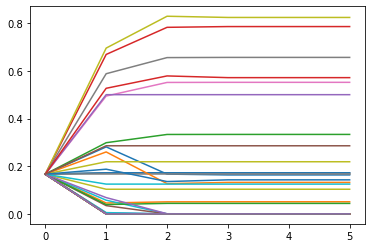

In [23]:
plot_probs(X, 6)

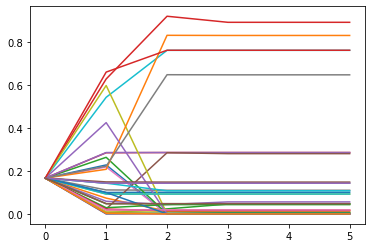

In [24]:
plot_probs(X_discrete, 6)

In [37]:
def simulate_traces(model, length, count):
    obs = [[-1 for col in range(length)] for row in range(count)]
    states = [[-1 for col in range(length)] for row in range(count)]
    for i in range(count):
        X, Z = model.sample(length)
        states[i] = Z
        for j in range(len(X)):
            probs = np.round(X[j], 6)
            obs[i][j] = np.random.choice(len(probs), 1, p=probs)[0]
    return np.array(obs), np.array(states)

In [68]:
obs, states = simulate_traces(model, 30, 10000)

In [69]:
def probability(observations, states, sequence):
    state_dict = {}
    found = 0
    for i in range(len(observations)):
        has_found = False
        obs = observations[i]
        state_trace = states[i]
        for j in range(len(obs) - len(sequence) + 1):
            sliced = obs[j:j + len(sequence)]
            if (sliced == sequence).all():
                if not has_found:
                    found += 1
                    has_found = True
                state_sliced = state_trace[j: j + len(sequence)]              
                state_tuple = tuple(state_sliced.tolist())
                if not state_tuple in state_dict:
                    state_dict[state_tuple] = 0
                state_dict[state_tuple] += 1
    prob = found / len(observations)
    return prob, state_dict

In [70]:
probability(obs, states, np.array([0, 3, 0])) # Oo1 -> Oo2 -> Oo1

(0.9901,
 {(0, 3, 0): 48515, (5, 3, 0): 130, (5, 5, 5): 6, (5, 5, 0): 13, (1, 4, 5): 1})

In [71]:
probability(obs, states, np.array([0, 1, 0])) # Oo1 -> Od1 -> Oo1

(0.1659,
 {(0, 1, 0): 1301,
  (0, 0, 0): 367,
  (0, 1, 1): 70,
  (1, 0, 0): 9,
  (5, 0, 0): 6,
  (1, 1, 0): 37,
  (0, 0, 1): 20,
  (1, 1, 1): 2})

In [72]:
probability(obs, states, np.array([3, 4, 3])) # Oo2 -> Od2 -> Oo2

(0.1776,
 {(3, 4, 3): 1479,
  (3, 3, 3): 227,
  (3, 4, 4): 99,
  (4, 4, 3): 64,
  (4, 3, 3): 7,
  (3, 4, 5): 70,
  (4, 4, 4): 6,
  (4, 4, 5): 1,
  (3, 3, 4): 12})

In [73]:
probability(obs, states, np.array([1, 4, 5])) # Od1 -> Od2 -> Ou2

(0.0179,
 {(1, 4, 5): 87,
  (1, 1, 4): 11,
  (1, 4, 4): 39,
  (0, 1, 2): 6,
  (0, 3, 4): 29,
  (0, 1, 4): 7,
  (1, 1, 2): 1})

In [74]:
probability(obs, states, np.array([1, 2, 5])) # Od1 -> Ou1 -> Ou2

(0.0132,
 {(1, 2, 5): 56,
  (1, 2, 2): 56,
  (0, 1, 2): 3,
  (1, 1, 4): 7,
  (0, 1, 4): 5,
  (1, 1, 2): 5})

In [75]:
probability(obs, states, np.array([2, 5, 0])) # Ou1 -> Ou2 -> Oo1

(0.0113,
 {(2, 2, 5): 11, (2, 2, 0): 33, (2, 5, 5): 22, (2, 5, 0): 38, (1, 2, 0): 10})